In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
#from pandas.plotting import table
%matplotlib inline
sns.set(style='whitegrid', color_codes = True)
from operator import itemgetter
from matplotlib import rc

In [2]:
ps = pd.read_csv('patch_seq_log_mouse.csv')

In [3]:
ps = ps[["Date", "User", "Post patch?", "Post patch pipette R", "Nucleus sucked in?", "Notes", "Internal version", "PCR cycles", "SM_QC_PF", "Resolution index", "Bad dates"]]
#ps.dropna(subset = ["SM_QC_PF", "Post patch?"], inplace = True)
ps.dropna(subset = ["Post patch?"], inplace = True)
ps["User"] = ps["User"].astype("category")
ps["Post patch?"] = ps["Post patch?"].astype("category")
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")
ps = ps[ps["Bad dates"] != 'x']
ps = ps[ps["SM_QC_PF"] != "cnt"]
ps = ps[ps["PCR cycles"] == 21]
ps = ps.drop('Bad dates', 1)
ps["Date"] = pd.to_datetime(ps["Date"], format = '%y%m%d')
#ps["PCR cycles"].value_counts()
ps.head()

,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,PCR cycles,SM_QC_PF,Resolution index
4968,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,21.0,fail,NaN
4969,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,21.0,pass,0.923406
4970,2017-04-19,P2,No-Seal,NaN,NaN,NaN,AiV2,21.0,fail,NaN
4971,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.000000
4972,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,21.0,pass,0.322631


#### defining counting functions

In [4]:
def get_count(x):    
    count = x["Post patch?"].count()
    return count

def calc_pct(part,total):
    pct = float(get_count(part)) / get_count(total)
    return pct

#### defining filtering functions

In [5]:
#input is a dataframe

def nucleated(x):
    nucleus = x[(x["Post patch?"] == "Nucleated") | (((x["Post patch?"] == "nucleus_visible") | (x["Post patch?"] == "nucleus_present")) & (x["Post patch pipette R"] >= 500))]
    return nucleus

def partial_nucleated(y):
    partial = y[(y["Post patch?"] == 'Partial-Nucleus') | (((y['Post patch?'] == 'nucleus_present') | (y['Post patch?'] == 'nucleus_visible')) & (y["Post patch pipette R"] <= 499))]
    return partial

def outside_out(z):
    outside = z[(z["Post patch?"] == 'Outside-Out') | (((z['Post patch?'] == 'nucleus_absent') | (z['Post patch?'] == 'no_nuclues_visible')) & (z['Post patch pipette R'] >= 500))]
    return outside

def no_seal(w): 
    no = w[(w["Post patch?"] == 'No-Seal') | (((w['Post patch?'] == 'nucleus_absent') | (w['Post patch?'] == 'no_nucleus_visible')) & (w['Post patch pipette R'] <= 499))]
    return no
    
def pass_only(df):
    pas = df[df["SM_QC_PF"] == "pass"]
    return pas

def gen_filter(df, col, cond):
    filtr = df[df[col] == cond]
    return filtr


In [6]:
#total = ps["Post patch?"].count()
total = get_count(ps)
total
#ps['Post patch?'].value_counts()

2044

# Post patch condition percentages

#### Filtering to nucleated patches only and calculating percentage

In [7]:
#nuc = ps[(ps["Post patch?"] == "Nucleated") | (ps["Post patch?"] == "Partial-Nucleus") | (ps["Post patch?"] == "nucleus_present") | (ps["Post patch?"] == "nucleus_visible")]
#nuc = ps[(ps["Post patch?"] == "Nucleated") | (((ps["Post patch?"] == "nucleus_visible") | (ps["Post patch?"] == "nucleus_present")) & (ps["Post patch pipette R"] >= 500))]
nuc = nucleated(ps)
nuc
nuc["post patch class"] = "Nucleated"
#nuc

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
#nuc_count = nuc["Post patch?"].count()
nuc_count = get_count(nuc)
nuc_count

937

In [9]:
#nuc_percent = float(nuc_count)/total
#nuc_percent
nuc_pct = calc_pct(nuc, ps) 
print "nucleated patch %:", nuc_pct

nucleated patch %: 0.458414872798


#### Filtering to partial-nucleated patches only and calculating percentage 

In [10]:
part_nuc = partial_nucleated(ps)
part_nuc["post patch class"] = "Partial nucleated"
#part_nuc
#part_nuc["Post patch pipette R"].value_counts()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
part_nuc_pct = calc_pct(part_nuc, ps)
print "partial nucleated patch %:", part_nuc_pct

partial nucleated patch %: 0.12866927593


#### Filtering to outside-out patches only and calculating percentage

In [12]:
out_out = outside_out(ps)
out_out["post patch class"] = "Outside out"
out_out
#out_out_pct = calc_pct(out_out, ps)
#print "outside_out %: ", out_out_pct
#out_out["Post patch pipette R"].value_counts()
#out_out["Post patch?"].value_counts()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,PCR cycles,SM_QC_PF,Resolution index,post patch class
4968,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,21.0,fail,NaN,Outside out
4969,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,21.0,pass,0.923406,Outside out
4972,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,21.0,pass,0.322631,Outside out
5001,2017-04-20,P2,Outside-Out,NaN,NaN,NaN,AiV2,21.0,pass,0.000000,Outside out
5008,2017-04-20,P2,Outside-Out,NaN,NaN,lost seal on cell during extraction,AiV2,21.0,pass,0.695597,Outside out
5098,2017-04-26,P1,Outside-Out,NaN,NaN,Cell Dimmed a few small bubbles,AiV2,21.0,fail,NaN,Outside out
5099,2017-04-26,P1,Outside-Out,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed lots of ...",AiV2,21.0,fail,NaN,Outside out
5100,2017-04-26,P1,Outside-Out,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed no bubbles",AiV2,21.0,fail,NaN,Outside out
5101,2017-04-26,P1,Outside-Out,NaN,NaN,Fluorescence in Pipette lots of small bubbles,AiV2,21.0,pass,0.322631,Outside out
5102,2017-04-26,P1,Outside-Out,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed lots of ...",AiV2,21.0,fail,NaN,Outside out


#### Filtering to no-seal patches only and calculating percentage

In [13]:
noSeal = no_seal(ps)
noSeal["post patch class"] = "No seal"
noSeal
noSeal_pct = calc_pct(noSeal, ps)
print "no seal %: ", noSeal_pct

no seal %:  0.338062622309


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### Filtering to entire cell patches only and claculating percentage

In [14]:
entirecell = ps[ps["Post patch?"] == "Entire-Cell"]
entirecell['post patch class'] = "Entire cell"
entirecell_pct = calc_pct(entirecell, ps)
entirecell_pct
#entirecell["Post patch?"].value_counts()
#entirecell

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


0.008317025440313111

In [15]:
frames = [nuc, part_nuc, out_out, noSeal, entirecell]
result = pd.concat(frames)
result

,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,PCR cycles,SM_QC_PF,Resolution index,post patch class
4971,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.000000,Nucleated
4973,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.322631,Nucleated
4975,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,NaN,Nucleated
4988,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.601033,Nucleated
4997,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,NaN,Nucleated
5009,2017-04-20,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.678447,Nucleated
5022,2017-04-21,P1,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed",AiV2,21.0,pass,0.795757,Nucleated
5026,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,1.000000,Nucleated
5027,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,0.877682,Nucleated
5035,2017-04-21,P2,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.556320,Nucleated


# Calculating nucleated patch percentages by user

In [16]:
P8_total = ps[ps["User"] == 'P8']
P8_total_count = P8_total['Post patch?'].count()
P8_total_count

472

In [17]:
#use post patch nucleated filter
P8_nuc = P8_total[P8_total['Post patch?'] == 'Nucleated']
P8_nuc_count = P8_nuc['Post patch?'].count()
P8_nuc_count

211

In [18]:
float(P8_nuc_count)/P8_total_count

0.4470338983050847

In [19]:
for riguser in ['P1','P2','P6','P8','P9','PA','PB']:
    user_total = ps[ps['User'] == riguser]
    user_nuc = nucleated(user_total)
    user_percent = calc_pct(user_nuc, user_total)
    print riguser,': ', user_percent
    
    #user_total_count = get_count(user_total)
    #user_total_count = user_total['Post patch?'].count()
    #user_nuc = user_total[user_total['Post patch?'] == 'Nucleated']
    #user_nuc_count = get_count(user_nuc)
    #user_nuc_count = user_nuc['Post patch?'].count()
    #user_percent = float(user_nuc_count)/(user_total_count)

P1 :  0.342490842491
P2 :  0.506086956522
P6 :  0.369863013699
P8 :  0.514830508475
P9 :  0.628865979381
PA :  0.477272727273
PB :  0.410714285714


# Obtaining nucleus dependant on internal solution version

                     SM_QC_PF  post patch class
Internal version                               
AiV2                      758               759
AiV2-50uM alexa 488       278               356


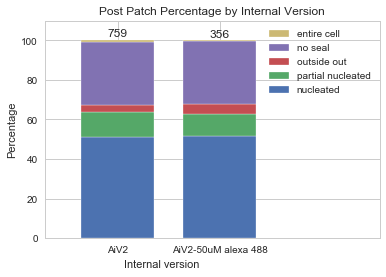

In [41]:
#sns.set(style='white', color_codes = True)
result2 = result[(result['User'] == 'P2') | (result['User'] == 'P8')]
result2 = result2.drop('Date',1)
result2 = result2.drop('User',1)
result2 = result2.drop('Post patch?',1)
result2 = result2.drop('Post patch pipette R',1)
result2 = result2.drop('Nucleus sucked in?',1)
result2 = result2.drop('Notes',1)
result2 = result2.drop('PCR cycles',1)
result2 = result2.drop('Resolution index',1)
totals = result2.groupby(['Internal version']).count()
print totals
#print result2
internal = result2.groupby(['Internal version', 'post patch class']).count()
#print internal
internal = internal.reset_index()
internal = internal.groupby(['Internal version'])
standard = internal.get_group('AiV2')
#standard_pp = standard.reset_index()
standard_pp = standard.groupby(['Internal version', 'post patch class']).agg({'SM_QC_PF': 'sum'})
standard_total = standard.reset_index()
standard_total = standard_total.groupby(['Internal version']).agg({'SM_QC_PF':'sum'})
standard_pcts = standard_pp.div(standard_total, level='Internal version')*100
alexa = internal.get_group('AiV2-50uM alexa 488')
#alexa_pp = alexa.reset_index()
alexa_pp = alexa.groupby(['Internal version', 'post patch class']).agg({'SM_QC_PF': 'sum'})
alexa_total = alexa.reset_index()
alexa_total = alexa_total.groupby(['Internal version']).agg({'SM_QC_PF': 'sum'})
alexa_pcts = alexa_pp.div(alexa_total, level='Internal version')*100
standard_pcts = standard_pcts.reset_index()
alexa_pcts = alexa_pcts.reset_index()
def make_list(post_patch):
    postpatch_std_pcts = standard_pcts[standard_pcts['post patch class']==post_patch]
    postpatch_alexa_pcts = alexa_pcts[alexa_pcts['post patch class']==post_patch]    #, alexa_pcts['post patch class']=='Nucleated'
#nucleated_pcts = list(nucleated_pcts)
    postpatch_pcts = [postpatch_std_pcts, postpatch_alexa_pcts]
    postpatch_pcts = pd.concat(postpatch_pcts)
    postpatch_pcts = postpatch_pcts['SM_QC_PF']
    return postpatch_pcts
nuc_pcts = make_list("Nucleated")
part_nuc_pcts = make_list("Partial nucleated")
out_out_pcts = make_list("Outside out")
no_seal_pcts = make_list("No seal")
entire_cell_pcts = make_list("Entire cell")

#print nuc_pcts
#print part_nuc_pcts
#print out_out_pcts
#print no_seal_pcts
#print entire_cell_pcts
fig, ax = plt.subplots(1)
r = [0.5,0.85]
#names = ['Nucleated', "Partial nucleated", "Outside out", "No seal", "Entire cell"]
names = ['AiV2', 'AiV2-50uM alexa 488']
labels = totals['post patch class']
#labels = ['759', '356']
barWidth = 0.25
nuc = plt.bar(r, nuc_pcts, edgecolor='white', width=barWidth)
part = plt.bar(r, part_nuc_pcts, edgecolor='white', bottom=nuc_pcts, width=barWidth)
out = plt.bar(r, out_out_pcts, edgecolor='white', bottom=[i+j for i,j in zip(nuc_pcts,part_nuc_pcts)], width=barWidth)
no = plt.bar(r, no_seal_pcts, edgecolor='white', bottom=[i+j+k for i,j,k in zip(nuc_pcts, part_nuc_pcts, out_out_pcts)], width=barWidth)
entire = plt.bar(r, entire_cell_pcts, edgecolor='white', bottom=[i+j+k+l for i,j,k,l in zip(nuc_pcts, part_nuc_pcts, out_out_pcts,no_seal_pcts)], width=barWidth)
#labels = ["label%d" % i for i in xrange(len(entire))]
for ent, label in zip(entire, labels):
    height = ent.get_height()
    ax.text(ent.get_x() + ent.get_width()/2, height + 100, label, ha='center', va='bottom')
plt.xticks(r, names)
plt.xlabel("Internal version")
plt.ylabel("Percentage")
axes = plt.gca()
axes.set_xlim(0.25,1.4)
axes.set_ylim([0,110])
ax.xaxis.set_label_coords(0.35,-0.1)
plt.title('Post Patch Percentage by Internal Version')
plt.legend((entire[0],no[0],out[0],part[0],nuc[0]), ('entire cell', 'no seal', 'outside out', 'partial nucleated', 'nucleated'), loc='upper right')
plt.savefig('post_patch_percentage_by_internal_version', dpi=300)

In [126]:
standard = "AiV2"
alexa = "AiV2-50uM alexa 488"
post_patch_condition = ['Nucleated', 'Partial nucleated', 'Outside out', 'No seal']
def postpatch_results(internal, postpatch):
    internal_version = gen_filter(result, "Internal version", internal)
    internal_version = internal_version[(internal_version["User"] == "P2") | (internal_version["User"] == "P8")]
    #for n in internal_version["post patch class"]:
    #for n in post_patch_condition:
    post_patch = gen_filter(internal_version, 'post patch class', postpatch)
    post_patch_pct = calc_pct(post_patch, internal_version)
    return post_patch_pct
    #print internal, n,': ', post_patch_pct
sn = postpatch_results(standard, "Nucleated")
sn_label = "Standard Nucleated" 
an = postpatch_results(alexa, "Nucleated")
an_label = "Alexa Nucleated"
spn = postpatch_results(standard, "Partial nucleated")
spn_label = "Standard Partial Nucleated"
print sn_label, sn    
print an_label, an
print spn_label, spn
#std = postpatch_results(standard)
#alexa488 = postpatch_results(alexa)
#std
#alexa488

Standard Nucleated 0.512516469038
Alexa Nucleated 0.510563380282
Standard Partial Nucleated 0.123847167325


# Rate of SMQC pass by internal solution verion

In [21]:
std_int = gen_filter(ps, "Internal version", "AiV2")
#std_int = ps[ps["Internal version"] == "AiV2"]
std_int.dropna(subset = ["SM_QC_PF", "Post patch?"], inplace = True)
std_int = std_int[(std_int["User"] == "P2") | (std_int["User"] == "P8")]
standard_internal_count = std_int["Post patch?"].count()
standard_internal_count

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


758

In [22]:
standard_internal_pass = std_int[std_int["SM_QC_PF"] == "pass"]
standard_internal_pass
standard_internal_pass_count = standard_internal_pass["Post patch?"].count()
standard_internal_pass_count                                    

661

In [23]:
print "Standard internal pass rate:" , float(standard_internal_pass_count)/standard_internal_count

Standard internal pass rate: 0.872031662269


In [24]:
alexa_int.dropna(subset = ["SM_QC_PF", "Post patch?"], inplace = True)
alexa_internal_count = alexa_int["Post patch?"].count()
alexa_internal_count

NameError: name 'alexa_int' is not defined

In [ ]:
alexa_internal_pass = alexa_int[alexa_int["SM_QC_PF"] == "pass"]
alexa_internal_pass_count = alexa_internal_pass["Post patch?"].count()
alexa_internal_pass_count

In [452]:
print "Alexa internal pass rate:" , float(alexa_internal_pass_count)/alexa_internal_count

Alexa internal pass rate: 0.797872340426


# Rate of SM_QC pass based on internal version and post patch condition

In [16]:
result["post patch class"].value_counts()

Nucleated            859
No seal              644
Partial nucleated    237
Outside out          111
Entire cell           17
Name: post patch class, dtype: int64

In [128]:
alexa = result[result["Internal version"] == "AiV2-50uM alexa 488"]
alexa["Internal version"].value_counts()
alexa = alexa[(alexa["User"] == "P2") | (alexa["User"] == "P8")]
alexa_count = get_count(alexa)
#alexa_count = alexa["post patch class"].count()
print alexa_count
alexa_pass = pass_only(alexa_internal)
alexa_pass_count = alexa_pass["Post patch?"].count()
print alexa_pass_count
alexa_nuc = nucleated(alexa)
alexa_nuc_count = get_count(alexa_nuc)
print alexa_nuc_count
alexa_nuc_pass = pass_only(alexa_nuc)
alexa_nuc_pass_count = get_count(alexa_nuc_pass)
alexa_nuc_pass_count

284


NameError: name 'alexa_internal' is not defined

In [16]:
result.dropna(subset = ["SM_QC_PF"], inplace=True)
result = result[result["SM_QC_PF"] != 'na']
result1 = result[(result["User"] == "P2") | (result["User"] == "P8")]
result1 = result1.drop('Date',1)
result1 = result1.drop('User',1)
result1 = result1.drop('Post patch?',1)
result1 = result1.drop('Post patch pipette R',1)
result1 = result1.drop('Nucleus sucked in?',1)
result1 = result1.drop('Notes',1)
result1 = result1.drop('PCR cycles',1)
result1 = result1.drop('Resolution index',1)
#print result["SM_QC_PF"].value_counts()
#print result["post patch class"].value_counts()

In [17]:
int_pp = result1.groupby(["Internal version", "post patch class"]).count()
#int_pp = int_pp.reset_index()
int_pp
#type(int_pp)
#result1["SM_QC_PF"].value_counts()

SM_QC_PF
Internal version    post patch class           
AiV2                Entire cell               6
                    No seal                 240
                    Nucleated               381
                    Outside out              28
                    Partial nucleated        94
AiV2-50uM alexa 488 Entire cell               1
                    No seal                  88
                    Nucleated               143
                    Outside out              15
                    Partial nucleated        31

In [18]:
int_pp_pass = pass_only(result1)
int_pp_pass["SM_QC_PF"].value_counts()
int_pp_pass = int_pp_pass.groupby(["Internal version", "post patch class"]).count()
#int_pp_pass = int_pp_pass.reset_index()
int_pp_pass

SM_QC_PF
Internal version    post patch class           
AiV2                Entire cell               5
                    No seal                 193
                    Nucleated               356
                    Outside out              22
                    Partial nucleated        85
AiV2-50uM alexa 488 Entire cell               1
                    No seal                  41
                    Nucleated               138
                    Outside out               5
                    Partial nucleated        22

In [19]:
#int_pp_totals = int_pp.groupby(["Internal version", "post patch class"]).agg({"SM_QC_PF": "sum"})
#int_pp_pass_totals = int_pp_pass.groupby(["Internal version", "post patch class"]).agg({"SM_QC_PF": "sum"})
int_pp_pass_pct = int_pp_pass.div(int_pp, level='Internal version') * 100
#type(int_pp_pass_pct)
int_pp_pass_pct["totals"] = int_pp["SM_QC_PF"]
int_pp_pass_pct = int_pp_pass_pct.reset_index()
int_pp_pass_pct = int_pp_pass_pct.groupby("Internal version")
#int_pp_pass_pct = int_pp_pass_pct.rename(columns = {'post patch class': 'Post patch outcome', 'SM_QC_PF': 'SM_QC_pass_pct'})
#int_pp_pass_pct = int_pp_pass_pct.rename(columns = {'SM_QC_PF': 'SM_QC pass percentage'})
#int_pp_pass_pct = int_pp_pass_pct.reindex([0,5,1,6,2,7,3,8,4,9])
std_group = int_pp_pass_pct.get_group("AiV2")
alexa_group = int_pp_pass_pct.get_group("AiV2-50uM alexa 488")
print std_group
print alexa_group
int_pp_pass_pct
#std_pp_pass_pct = int_pp_pass_pct[int_pp_pass_pct["Internal version"] == "AiV2"]
#alexa_pp_pass_pct = int_pp_pass_pct[int_pp_pass_pct["Internal version"] == "AiV2-50uM alexa 488"]

  Internal version   post patch class   SM_QC_PF  totals
0             AiV2        Entire cell  83.333333       6
1             AiV2            No seal  80.416667     240
2             AiV2          Nucleated  93.438320     381
3             AiV2        Outside out  78.571429      28
4             AiV2  Partial nucleated  90.425532      94
      Internal version   post patch class    SM_QC_PF  totals
5  AiV2-50uM alexa 488        Entire cell  100.000000       1
6  AiV2-50uM alexa 488            No seal   46.590909      88
7  AiV2-50uM alexa 488          Nucleated   96.503497     143
8  AiV2-50uM alexa 488        Outside out   33.333333      15
9  AiV2-50uM alexa 488  Partial nucleated   70.967742      31


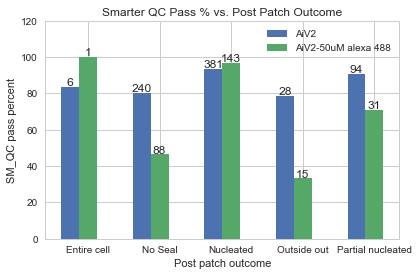

In [47]:
n_groups = 5

standard = list(std_group["SM_QC_PF"])
std_tots = list(std_group["totals"])
alexa = list(alexa_group["SM_QC_PF"])
alexa_tots = list(alexa_group["totals"])
#print standard
fig,ax = plt.subplots()
index = np.arange(n_groups)
#print index
bar_width = 0.25
#print std_tots

rects1 = plt.bar(index, standard, bar_width, color='b', label='AiV2')
for ii,rect in enumerate(rects1):
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()-.125, 1.01*height, std_tots[ii], ha='center')

rects2 = plt.bar(index+bar_width, alexa, bar_width, color='g', label='AiV2-50uM alexa 488')
for ii,rect in enumerate(rects2):
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()-.125, 1.01*height, alexa_tots[ii], ha = 'center')

plt.title("Smarter QC Pass % vs. Post Patch Outcome")
plt.xlabel('Post patch outcome')
plt.ylabel('SM_QC pass percent')
axes = plt.gca()
axes.set_ylim([0,120])
plt.xticks(index + bar_width, ('Entire cell', 'No Seal', 'Nucleated', 'Outside out', 'Partial nucleated'))
plt.legend()
plt.tight_layout()
plt.savefig('SM_QC_pass_vs_postpatch_by_internal_version.png', dpi=300)

In [20]:
internal = result1.groupby(['Internal version']).count()
internal

,SM_QC_PF,post patch class
Internal version,,
AiV2,749,749
AiV2-50uM alexa 488,278,278


In [21]:
internal_pass = pass_only(result1)
internal_pass = internal_pass.groupby(['Internal version']).count()
internal_pass

,SM_QC_PF,post patch class
Internal version,,
AiV2,661,661
AiV2-50uM alexa 488,207,207


In [32]:
internal_pass_pct = internal_pass.div(internal, level='Internal version')*100
internal_pass_pct = internal_pass_pct.drop('post patch class', 1)
internal_pass_pct = internal_pass_pct.reset_index()
internal_pass_pct

,Internal version,SM_QC_PF
0,AiV2,88.251001
1,AiV2-50uM alexa 488,74.460432


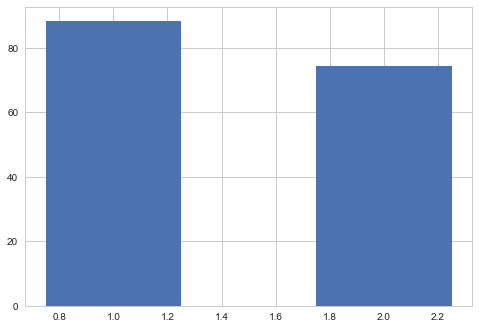

In [35]:
#internal_pass_pct = sns.load_dataset('internal_pass_pct')
#ax = sns.barplot(x='Internal version', y = 'SM_QC_PF', data='internal_pass_pct')
fig, ax = plt.subplots()
r = [1,2]
internal = list(internal_pass_pct['Internal version'])
pass_rate = list(internal_pass_pct['SM_QC_PF'])
bar_width = 0.5
pcts = plt.bar(r, pass_rate, bar_width)

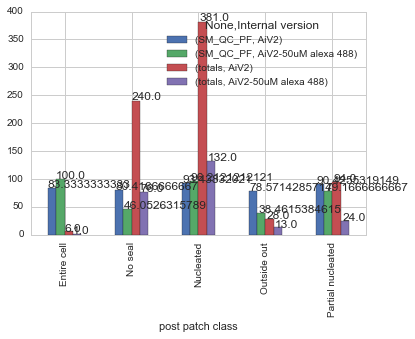

In [231]:

ax = int_pp_pass_pct.unstack(level=0).plot(kind='bar', subplots=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()*1.005, p.get_height()*1.005))

In [ ]:
internal_postpatch_passpct = sns.barplot(x = 'post patch class', y = 'SM_QC_PF', hue='Internal version',  data=int_pp_pass_pct)   
internal_postpatch_passpct.set(ylabel = 'SM_QC pass %')
plt.legend(loc = 'upper right')
plt.title('Smarter QC Pass % vs Post Patch Outcome')
#y = int_pp_pass_pct["totals"]
for index, row in int_pp_pass_pct.iterrows():
    internal_postpatch_passpct.text(row.name, row.SM_QC_PF, round(row.totals,2), color='black', ha='center')
#for i, v in enumerate(int_pp_pass_pct["totals"]):
    #internal_postpatch_passpct.text(v, i, str(v), color = 'black')
    
    
    
    
    
    
    
    
#plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
plt.savefig('SM_QC_pass_vs_postpatch_by_internal_version.png', dpi=300)
#for item in internal_postpatch_passpct.get_xticklables():
    #item.set_rotation(90)

In [ ]:
plt.table(cellText = int_pp_summary.values,
         rowLabels=int_pp_summary.index,
         colLabels=int_pp_summary.columns,
         cellLoc='center', rowLoc='center',loc='top')

In [ ]:
print result["SM_QC_PF"].value_counts()
print result["Internal version"].value_counts()

In [ ]:
result.dropna(subset = ["SM_QC_PF"], inplace=True)
result = result[result["SM_QC_PF"] != 'na']
standard = "AiV2"
alexa = "AiV2-50uM alexa 488"
#post_patch_condition = ['Nucleated', "Partial nucleated", "Outside out", "No seal", "Entire cell"]
def pass_pct_results(internal, postpatch):
    int_ver = gen_filter(result, "Internal version", internal)
    #int_ver_count = int_ver["Post patch?"].count
    int_ver = int_ver[(int_ver["User"] == "P2") | (int_ver["User"] == "P8")]
    #for n in post_patch_condition:
    post_patch = gen_filter(int_ver,"post patch class", postpatch)
    post_patch_pass = pass_only(post_patch)
    post_patch_pass_count = get_count(post_patch_pass)
    post_patch_pass_pct = calc_pct(post_patch_pass, post_patch)
    #print internal, n,': ', post_patch_pass_pct
    return post_patch_pass_pct, post_patch_pass_count
    #if internal == standard:
#pass_pct_results(alexa)
#pass_pct_results(standard)
x1 = "Standard Nucleated"
y1 = pass_pct_results(standard, "Nucleated")
x2 = "Alexa Nucleated"
y2 = pass_pct_results(alexa, "Nucleated")
x3 = "Standard Partial Nucleated"
y3 = pass_pct_results(standard, "Partial nucleated")
x4 = "Alexa Partial Nucleated"
y4 = pass_pct_results(alexa, "Partial nucleated")
x5 = "Standard Outside Out"
y5 = pass_pct_results(standard, "Outside out")
x6 = "Alexa Outside Out"
y6 = pass_pct_results(alexa, "Outside out")

#std_lbl = (x1, x3)
#alx_lbl = (x2, x4)
#N = 2
#standard_postpatch = (y1, y3)
#alexa_postpatch = (y2, y4)
#ind = np.arange(N)
#width = 0.35

#fig, ax = plt.subplots()
#rects1 = ax.bar(ind, standard_postpatch, width, color = 'y')

print x1, y1
print x2, y2
print x3, y3
print x4, y4
print x5, y5
print x6, y6


In [ ]:
fig, axs = plt.subplots()
axs[0].bar(x1, y1)
#axs[1].scatter(x1, y1)
#axs[2].plot(x1, y1)

# Resolution Index vs post patch condition for pre and post alexa experiments

In [73]:
result.dropna(subset = ["Resolution index"], inplace=True)

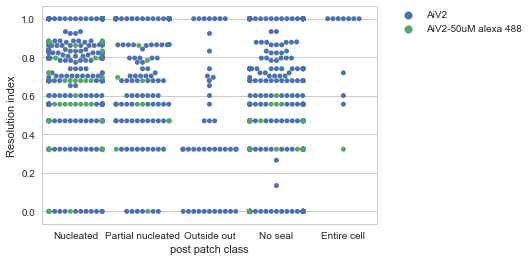

In [74]:
sns.swarmplot(x = "post patch class", y = "Resolution index", hue = "Internal version", data=result)
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)

In [167]:
result["Internal version"].value_counts()

AiV2                   1038
AiV2-50uM alexa 488      22
Name: Internal version, dtype: int64

In [168]:
post_alexa = gen_filter(result, 'Internal version', alexa)
post_alexa_count = get_count(post_alexa)
post_alexa_count

ValueError: Series lengths must match to compare

In [ ]:
sns.swarmplot(x = "post patch class", y = "Resolution index", data=post_alexa)

In [ ]:
pre_alexa = gen_filter(result, 'Internal version', standard)
pre_alexa_count = get_count(pre_alexa)
pre_alexa_count

In [ ]:
sns.swarmplot(x = "post patch class", y = "Resolution index", data=pre_alexa)